In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA

from mydatools.plot import plot_grid_search_result

% matplotlib inline

In [2]:
train_df = pd.read_csv('./data/input/train.csv')
test_df = pd.read_csv('./data/input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

dropoff_datetime  dropoff_latitude  dropoff_longitude         id  \
train 0  2016-03-14 17:32:30         40.765602         -73.964630  id2875421   
      1  2016-06-12 00:54:38         40.731152         -73.999481  id2377394   
      2  2016-01-19 12:10:48         40.710087         -74.005333  id3858529   
      3  2016-04-06 19:39:40         40.706718         -74.012268  id3504673   
      4  2016-03-26 13:38:10         40.782520         -73.972923  id2181028   

         passenger_count      pickup_datetime  pickup_latitude  \
train 0                1  2016-03-14 17:24:55        40.767937   
      1                1  2016-06-12 00:43:35        40.738564   
      2                1  2016-01-19 11:35:24        40.763939   
      3                1  2016-04-06 19:32:31        40.719971   
      4                1  2016-03-26 13:30:55        40.793209   

         pickup_longitude store_and_fwd_flag  trip_duration  vendor_id  
train 0        -73.982155                  N          455.0          2  
      1        -73.980415                  N          663.0          1  
      2        -73.979027                  N         2124.0          2  
      3        -74.010040                  N          429.0          2  
      4        -73.973053                  N          435.0          2

In [3]:
full_df['log1p_trip_duration'] = np.log1p(full_df['trip_duration'])

## feature

In [4]:
feature_columns = [
    'passenger_count', 'vendor_id',
    'store_and_fwd_flag',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude', 
]

In [5]:
def add_features(features):
    if type(features) != list:
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

In [6]:
full_df['store_and_fwd_flag'] = full_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

* Addition Data

https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm

In [7]:
usecols = ['id', 'total_distance', 'total_travel_time', 'number_of_steps']
fr_df = pd.concat([    
    pd.read_csv('./data/input/fastest_routes_train_part_1.csv', usecols=usecols),
    pd.read_csv('./data/input/fastest_routes_train_part_2.csv', usecols=usecols),
    pd.read_csv('./data/input/fastest_routes_test.csv', usecols=usecols),
])

In [8]:
full_df_index = full_df.index
full_df = full_df.merge(fr_df, how='left', on='id')
full_df.index = full_df_index

In [9]:
add_features(['total_distance', 'total_travel_time', 'number_of_steps'])

* generate datetime features

In [10]:
def gen_datetime_feature(prefix):
    # datetime features
    f_datetime = prefix + '_datetime'
    attr_list = [
#         'year', 
        'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear',
        'hour', 'minute',
    ]

    full_df[f_datetime] = pd.to_datetime(full_df[f_datetime])
    for attr in attr_list:
        full_df[prefix+'_'+attr] = eval("full_df[f_datetime].dt."+attr)
        add_features(prefix+'_'+attr)
    
    full_df[prefix+'_hour_minute'] = full_df[prefix+'_hour'] * 60 + full_df[prefix+'_minute']
    full_df[prefix+'_week_hour'] = full_df[prefix+'_dayofweek'] * 24 + full_df[prefix+'_hour']
    full_df[prefix+'_week_hour_minute'] = full_df[prefix+'_week_hour'] * 60 + full_df[prefix+'_minute']
    full_df[prefix+'_total_seconds'] = (full_df[f_datetime] - full_df[f_datetime].min()).dt.total_seconds()
    add_features([
        prefix+'_hour_minute', prefix+'_week_hour',
        prefix+'_week_hour_minute', prefix+'_total_seconds',
    ])
    
    full_df[prefix+'_date'] = full_df[f_datetime].dt.date

gen_datetime_feature('pickup')
# gen_datetime_feature('dropoff') # 注意 这个不能用 下车时间是结果的一个信息

* riding distance

In [11]:
xy_distance = np.c_[
    (full_df['dropoff_latitude'] - full_df['pickup_latitude']).values,
    (full_df['dropoff_longitude'] - full_df['pickup_longitude']).values,
]
full_df['distance_p2'] = np.linalg.norm(xy_distance, 2, axis=1)
full_df['distance_p1'] = np.linalg.norm(xy_distance, 1, axis=1)
add_features(['distance_p2', 'distance_p1'])

* pos(longitude/latitude) speed

In [12]:
min_longitude, max_longitude = -74.5, -73.5
min_latitude, max_latitude = 40.4, 41.1
    
pos_feats = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

将经纬度分割成一格一格 每一格取速度平均值

In [13]:
# 分割的间隔
pos_interval = 0.01
max_longitude_idx = int((max_longitude - min_longitude) // 0.01)
max_latitude_idx = int((max_latitude - min_latitude) // 0.01)

# 获取每条数据的pos_idx
for posf in pos_feats:
    pos_type = posf.split('_')[1]
    min_v, max_v = eval('min_'+pos_type), eval('max_'+pos_type)
    idx_df = (full_df[posf].clip(min_v, max_v) - min_v) // pos_interval
    idx_df = np.where(idx_df > 0, idx_df, 0) # 没有这个操作会有负数
    full_df['idx_'+posf] = idx_df.astype('int')

In [14]:
# 速度
full_df['speed'] = (full_df['distance_p2'] / full_df['trip_duration'] * 3600).clip(0, 1)
full_df['speed_p1'] = (full_df['distance_p1'] / full_df['trip_duration'] * 3600).clip(0, 1)

In [15]:
# 将df扩充至(0,max_index)和(0,max_columns)
def get_dense_df(df, max_index, max_columns):
    res_df = pd.DataFrame(np.zeros((max_index, max_columns)))
    res_df.iloc[df.index.astype(int), df.columns.astype(int)] = df.values
    return res_df

In [16]:
# 获取上车/下车地点速度（根据train数据）
pickup_speed_dist = full_df.loc['train'].groupby(['idx_pickup_longitude', 'idx_pickup_latitude'])['speed'].mean().unstack()
dropoff_speed_dist = full_df.loc['train'].groupby(['idx_dropoff_longitude', 'idx_dropoff_latitude'])['speed'].mean().unstack()
pickup_speed_dist = get_dense_df(pickup_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values
dropoff_speed_dist = get_dense_df(dropoff_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values

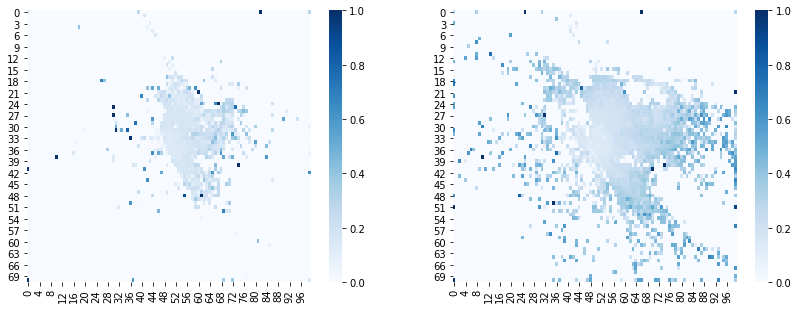

In [17]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

sns.heatmap(pickup_speed_dist.T, cmap=plt.cm.Blues, ax=ax[0])
sns.heatmap(dropoff_speed_dist.T, cmap=plt.cm.Blues, ax=ax[1])

In [18]:
# 根据train的位置速度 计算train/test的位置速度

# 这个方法太慢了
# full_df['pickup_pos_speed'] = full_df.apply(lambda df: pickup_speed_dist.values[df['idx_pickup_longitude'], df['idx_pickup_latitude']], axis=1)

full_df['pickup_pos_speed'] = 0
full_df['dropoff_pos_speed'] = 0

# for i in range(max_longitude_idx+1):
#     pickup_cond1 = (full_df['idx_pickup_longitude'] == i)
#     dropoff_cond1 = (full_df['idx_dropoff_longitude'] == i)

#     for j in range(max_latitude_idx+1):
#         pickup_cond2 = (full_df['idx_pickup_latitude'] == j)
#         dropoff_cond2 = (full_df['idx_dropoff_latitude'] == j)
        
#         full_df.loc[pickup_cond1 & pickup_cond2, 'pickup_pos_speed'] = pickup_speed_dist[i][j]
#         full_df.loc[dropoff_cond1 & dropoff_cond2, 'dropoff_pos_speed'] = dropoff_speed_dist[i][j]
        
# full_df[['pickup_pos_speed', 'dropoff_pos_speed']].to_csv('./data/input/tmp_pos_speed.csv', index=False)

full_df[['pickup_pos_speed', 'dropoff_pos_speed']] = pd.read_csv('./data/input/tmp_pos_speed.csv').values

add_features(['pickup_pos_speed', 'dropoff_pos_speed'])

In [19]:
# 计算起点到终点范围内的速度

full_df['range_speed_by_pickup_speed'] = 0
full_df['range_speed_by_dropoff_speed'] = 0

# # 计算哪些位置是非0的
# pickup_speed_dist_isnotnan = np.where(pickup_speed_dist == 0, 0, 1)
# dropoff_speed_dist_isnotnan = np.where(dropoff_speed_dist == 0, 0, 1)

# full_df['min_idx_longitude'] = full_df[['idx_pickup_longitude', 'idx_dropoff_longitude']].min(axis=1)
# full_df['max_idx_longitude'] = full_df[['idx_pickup_longitude', 'idx_dropoff_longitude']].max(axis=1)
# full_df['min_idx_latitude'] = full_df[['idx_pickup_latitude', 'idx_dropoff_latitude']].min(axis=1)
# full_df['max_idx_latitude'] = full_df[['idx_pickup_latitude', 'idx_dropoff_latitude']].max(axis=1)

# full_df['range_speed_by_pickup_speed'] = full_df.apply(
#     lambda df: 
#         pickup_speed_dist[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum() / 
#         pickup_speed_dist_isnotnan[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum(),
#     axis=1).fillna(0)

# full_df['range_speed_by_dropoff_speed'] = full_df.apply(
#     lambda df: 
#         dropoff_speed_dist[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum() / 
#         dropoff_speed_dist_isnotnan[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum(),
#     axis=1).fillna(0)

# full_df[['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed']].to_csv('./data/input/tmp_range_speed.csv', index=False)

full_df[['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed']] = pd.read_csv('./data/input/tmp_range_speed.csv').values

add_features(['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed'])

* PCA coordinates

对坐标PCA后，虽然维度没有变，仍然是2D，但是有助于树模型分类

In [20]:
coords = np.vstack((
    full_df[['pickup_latitude', 'pickup_longitude']].values,
    full_df[['dropoff_latitude', 'dropoff_longitude']].values,
))

pca = PCA().fit(coords)

new_feats = ['pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1']
for f in new_feats:
    full_df[f] = 0

full_df[['pickup_pca0', 'pickup_pca1']] = pca.transform(full_df[['pickup_latitude', 'pickup_longitude']])
full_df[['dropoff_pca0', 'dropoff_pca1']] = pca.transform(full_df[['dropoff_latitude', 'dropoff_longitude']])

add_features(new_feats)

## EDA

In [21]:
tdf = full_df.copy()

tdf = tdf[tdf['trip_duration'] < 500000]
tdf = tdf[tdf['pickup_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['pickup_latitude'].between(min_latitude, max_latitude)]
tdf = tdf[tdf['dropoff_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['dropoff_latitude'].between(min_latitude, max_latitude)]

* 上车/下车地点分布

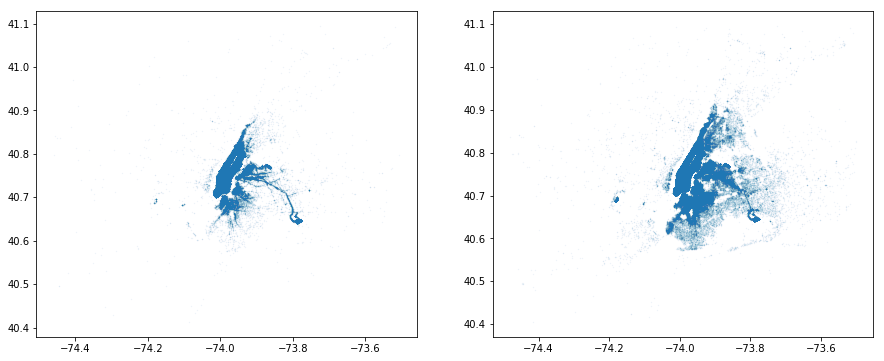

In [22]:
plt.subplots(1, 2, figsize=(15,6))

plt.subplot(121)
plt.scatter(tdf['pickup_longitude'], tdf['pickup_latitude'], s=0.1, alpha=0.1)

plt.subplot(122)
plt.scatter(tdf['dropoff_longitude'], tdf['dropoff_latitude'], s=0.1, alpha=0.1)

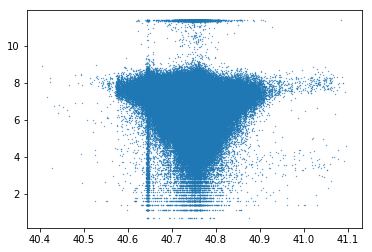

In [23]:
# plt.scatter(tdf['distance'], tdf['log1p_trip_duration'], s=0.1) # 这个有明显的关系
plt.scatter(tdf['dropoff_latitude'], tdf['log1p_trip_duration'], s=0.1)

* 可以看到 不同的位置 行驶的速度还是有区别的 

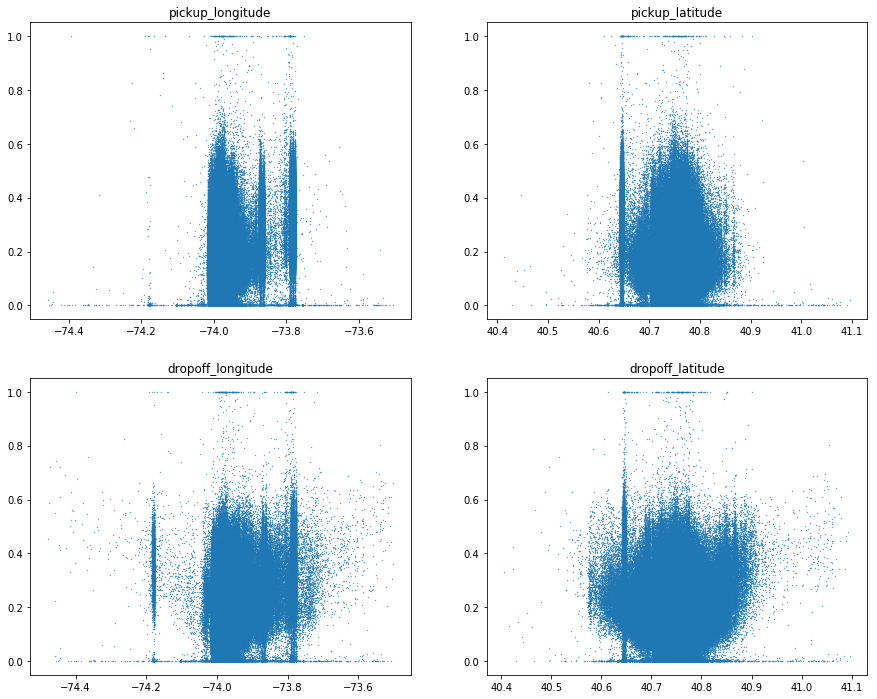

In [24]:
def show_pos(df, f):
    plt.subplots(2, 2, figsize=(15,12))
 
    for i, posf in enumerate(pos_feats):
        plt.subplot(2,2,i+1)
        plt.scatter(tdf[posf], tdf[f], s=0.1)
        plt.title(posf)
        
show_pos(tdf, 'speed')

* 速度跟周几还是很有关系的

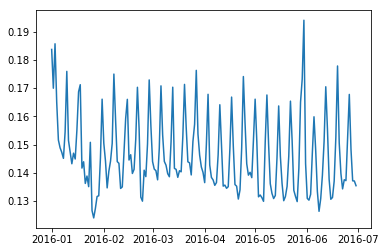

In [25]:
plt.plot(tdf.groupby(tdf['pickup_datetime'].dt.date)['speed'].mean())

* 不同的vendor_id速度是基本一样的，但是vendor_id=1比较偏向于接时间短的单子

In [26]:
vendor_date_speed_df = tdf.groupby([tdf['vendor_id'], tdf['pickup_date']], as_index=False)[['log1p_trip_duration', 'speed']].mean()

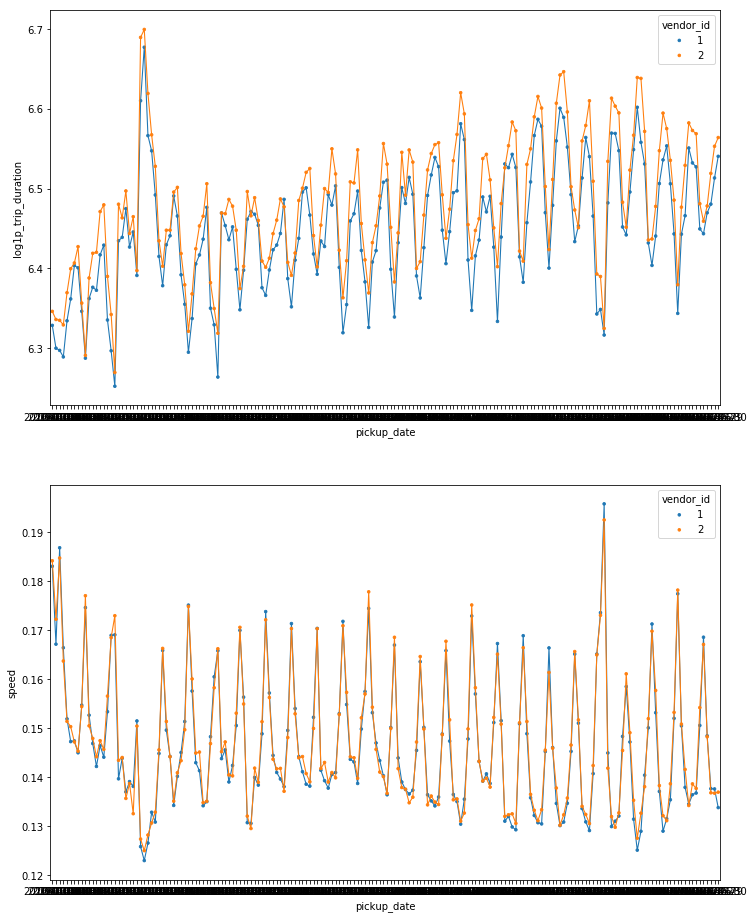

In [27]:
fig, ax = plt.subplots(2,1,figsize=(12,16))
sns.pointplot('pickup_date', 'log1p_trip_duration', 'vendor_id', data=vendor_date_speed_df, scale=0.4, ax=ax[0])
sns.pointplot('pickup_date', 'speed', 'vendor_id', data=vendor_date_speed_df, scale=0.4, ax=ax[1])

* 日订单数

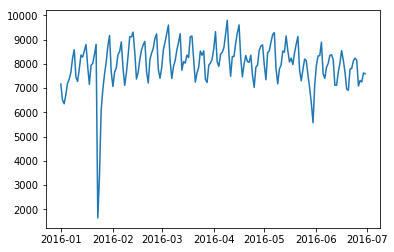

In [28]:
plt.plot(tdf.groupby(tdf['pickup_datetime'].dt.date).size())

## 相关性

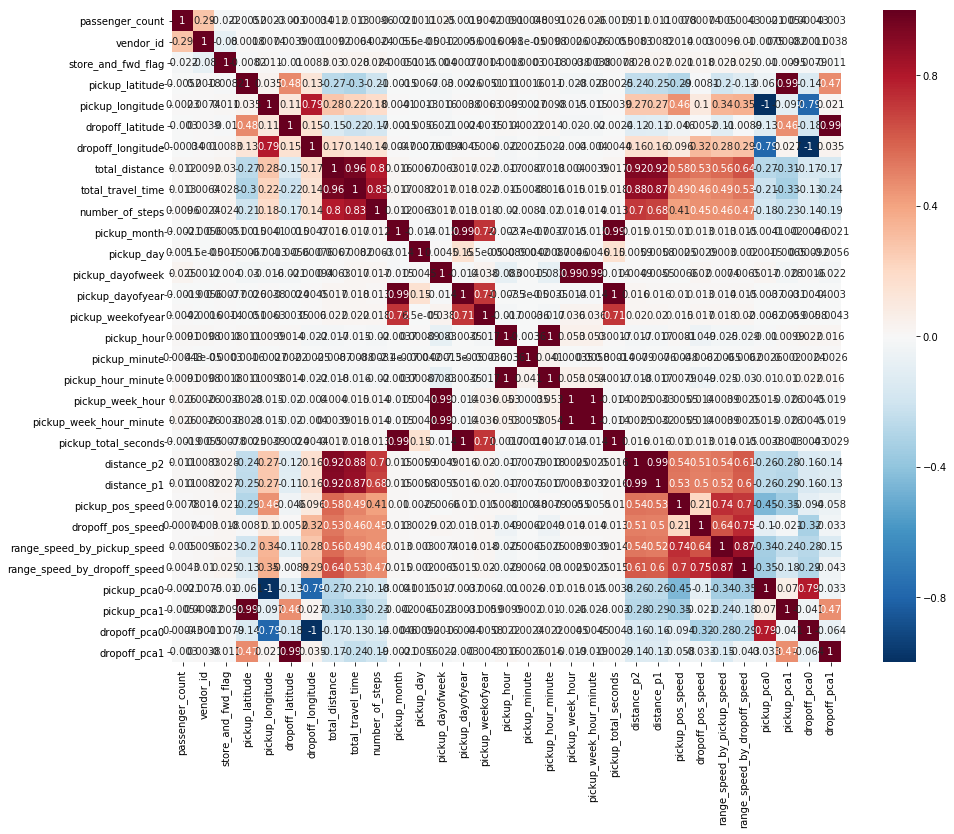

In [29]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
corr_df = full_df[feature_columns].corr()
sns.heatmap(corr_df, annot=True, cmap=plt.cm.RdBu_r)

## 预处理

In [30]:
trn_df = full_df.loc['train']
tst_df = full_df.loc['test']

X = trn_df[feature_columns].values
y = trn_df['log1p_trip_duration'].values
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns].values
# y_tst = tst_df['log1p_trip_duration'].values

trn_lgb = lgb.Dataset(X_trn, y_trn, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, y_val, free_raw_data=False, reference=trn_lgb)

## LightGBM

In [31]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.2,
#     'max_depth': 5,
#     'num_leaves': 20,
#     'subsample': 0.8,
#     'colsample_bytree': 0.5,
#     'min_child_weight': 3, 
#     'min_child_samples': 6,
#     'reg_alpha': 0.01,
    'verbose': 1,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)
bst.save_model('./data/output/model.txt')

[1]	training's rmse: 0.695727	valid_1's rmse: 0.693743
Train until valid scores didn't improve in 20 rounds.
[2]	training's rmse: 0.621445	valid_1's rmse: 0.619537
[3]	training's rmse: 0.567126	valid_1's rmse: 0.565339
[4]	training's rmse: 0.528084	valid_1's rmse: 0.526376
[5]	training's rmse: 0.499924	valid_1's rmse: 0.498253
[6]	training's rmse: 0.47981	valid_1's rmse: 0.4781
[7]	training's rmse: 0.464593	valid_1's rmse: 0.463019
[8]	training's rmse: 0.454279	valid_1's rmse: 0.452766
[9]	training's rmse: 0.445869	valid_1's rmse: 0.444564
[10]	training's rmse: 0.440001	valid_1's rmse: 0.438751
[11]	training's rmse: 0.435016	valid_1's rmse: 0.433857
[12]	training's rmse: 0.43136	valid_1's rmse: 0.430224
[13]	training's rmse: 0.428498	valid_1's rmse: 0.427321
[14]	training's rmse: 0.426262	valid_1's rmse: 0.425136
[15]	training's rmse: 0.424242	valid_1's rmse: 0.423131
[16]	training's rmse: 0.422319	valid_1's rmse: 0.421268
[17]	training's rmse: 0.420879	valid_1's rmse: 0.419858
[18]	tr

[148]	training's rmse: 0.380984	valid_1's rmse: 0.3883
[149]	training's rmse: 0.380921	valid_1's rmse: 0.388282
[150]	training's rmse: 0.380807	valid_1's rmse: 0.388291
[151]	training's rmse: 0.380699	valid_1's rmse: 0.38828
[152]	training's rmse: 0.380552	valid_1's rmse: 0.388169
[153]	training's rmse: 0.380444	valid_1's rmse: 0.388086
[154]	training's rmse: 0.380383	valid_1's rmse: 0.38804
[155]	training's rmse: 0.380169	valid_1's rmse: 0.388064
[156]	training's rmse: 0.380111	valid_1's rmse: 0.388045
[157]	training's rmse: 0.380032	valid_1's rmse: 0.38801
[158]	training's rmse: 0.37991	valid_1's rmse: 0.387967
[159]	training's rmse: 0.379792	valid_1's rmse: 0.387862
[160]	training's rmse: 0.379604	valid_1's rmse: 0.387888
[161]	training's rmse: 0.379461	valid_1's rmse: 0.387778
[162]	training's rmse: 0.379415	valid_1's rmse: 0.387755
[163]	training's rmse: 0.379318	valid_1's rmse: 0.387768
[164]	training's rmse: 0.379238	valid_1's rmse: 0.387755
[165]	training's rmse: 0.379134	valid

[295]	training's rmse: 0.368695	valid_1's rmse: 0.383788
[296]	training's rmse: 0.368615	valid_1's rmse: 0.383754
[297]	training's rmse: 0.368523	valid_1's rmse: 0.383716
[298]	training's rmse: 0.368437	valid_1's rmse: 0.383704
[299]	training's rmse: 0.368393	valid_1's rmse: 0.383693
[300]	training's rmse: 0.368285	valid_1's rmse: 0.383632
[301]	training's rmse: 0.368212	valid_1's rmse: 0.38362
[302]	training's rmse: 0.368132	valid_1's rmse: 0.383635
[303]	training's rmse: 0.368092	valid_1's rmse: 0.383643
[304]	training's rmse: 0.368048	valid_1's rmse: 0.383662
[305]	training's rmse: 0.367989	valid_1's rmse: 0.383627
[306]	training's rmse: 0.367892	valid_1's rmse: 0.383572
[307]	training's rmse: 0.367784	valid_1's rmse: 0.383531
[308]	training's rmse: 0.367689	valid_1's rmse: 0.383517
[309]	training's rmse: 0.367583	valid_1's rmse: 0.383507
[310]	training's rmse: 0.367523	valid_1's rmse: 0.383494
[311]	training's rmse: 0.367465	valid_1's rmse: 0.383446
[312]	training's rmse: 0.367388	

[440]	training's rmse: 0.360279	valid_1's rmse: 0.381254
[441]	training's rmse: 0.360242	valid_1's rmse: 0.381229
[442]	training's rmse: 0.360187	valid_1's rmse: 0.381252
[443]	training's rmse: 0.360163	valid_1's rmse: 0.381244
[444]	training's rmse: 0.360127	valid_1's rmse: 0.381233
[445]	training's rmse: 0.360062	valid_1's rmse: 0.381196
[446]	training's rmse: 0.36002	valid_1's rmse: 0.381182
[447]	training's rmse: 0.359951	valid_1's rmse: 0.381163
[448]	training's rmse: 0.359898	valid_1's rmse: 0.381142
[449]	training's rmse: 0.359855	valid_1's rmse: 0.381142
[450]	training's rmse: 0.359791	valid_1's rmse: 0.381097
[451]	training's rmse: 0.359728	valid_1's rmse: 0.381121
[452]	training's rmse: 0.359647	valid_1's rmse: 0.381121
[453]	training's rmse: 0.359583	valid_1's rmse: 0.381105
[454]	training's rmse: 0.359514	valid_1's rmse: 0.381138
[455]	training's rmse: 0.359479	valid_1's rmse: 0.38115
[456]	training's rmse: 0.359425	valid_1's rmse: 0.381161
[457]	training's rmse: 0.359356	v

[586]	training's rmse: 0.353635	valid_1's rmse: 0.379893
[587]	training's rmse: 0.3536	valid_1's rmse: 0.379891
[588]	training's rmse: 0.353568	valid_1's rmse: 0.379885
[589]	training's rmse: 0.353523	valid_1's rmse: 0.379886
[590]	training's rmse: 0.353495	valid_1's rmse: 0.379881
[591]	training's rmse: 0.353418	valid_1's rmse: 0.379872
[592]	training's rmse: 0.353354	valid_1's rmse: 0.379871
[593]	training's rmse: 0.35333	valid_1's rmse: 0.379865
[594]	training's rmse: 0.353299	valid_1's rmse: 0.37987
[595]	training's rmse: 0.353249	valid_1's rmse: 0.379854
[596]	training's rmse: 0.353224	valid_1's rmse: 0.379853
[597]	training's rmse: 0.353185	valid_1's rmse: 0.379846
[598]	training's rmse: 0.353154	valid_1's rmse: 0.379842
[599]	training's rmse: 0.35311	valid_1's rmse: 0.379847
[600]	training's rmse: 0.353083	valid_1's rmse: 0.379833
[601]	training's rmse: 0.353046	valid_1's rmse: 0.37983
[602]	training's rmse: 0.352997	valid_1's rmse: 0.379808
[603]	training's rmse: 0.352946	valid

In [32]:
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
                init_model='./data/output/model.txt', 
                learning_rates=lambda iter: 0.2 * (0.99 ** iter))

[687]	training's rmse: 0.349962	valid_1's rmse: 0.379362
Train until valid scores didn't improve in 20 rounds.
[688]	training's rmse: 0.349926	valid_1's rmse: 0.379374
[689]	training's rmse: 0.349895	valid_1's rmse: 0.379392
[690]	training's rmse: 0.34987	valid_1's rmse: 0.3794
[691]	training's rmse: 0.349843	valid_1's rmse: 0.37941
[692]	training's rmse: 0.349779	valid_1's rmse: 0.379397
[693]	training's rmse: 0.349748	valid_1's rmse: 0.379402
[694]	training's rmse: 0.349722	valid_1's rmse: 0.379398
[695]	training's rmse: 0.349696	valid_1's rmse: 0.379392
[696]	training's rmse: 0.349658	valid_1's rmse: 0.379392
[697]	training's rmse: 0.349644	valid_1's rmse: 0.379393
[698]	training's rmse: 0.34962	valid_1's rmse: 0.379391
[699]	training's rmse: 0.349595	valid_1's rmse: 0.379382
[700]	training's rmse: 0.349559	valid_1's rmse: 0.379373
[701]	training's rmse: 0.349514	valid_1's rmse: 0.379359
[702]	training's rmse: 0.349471	valid_1's rmse: 0.379338
[703]	training's rmse: 0.349446	valid_1

[834]	training's rmse: 0.347191	valid_1's rmse: 0.378881
[835]	training's rmse: 0.347186	valid_1's rmse: 0.378884
[836]	training's rmse: 0.347179	valid_1's rmse: 0.378884
[837]	training's rmse: 0.347173	valid_1's rmse: 0.378882
[838]	training's rmse: 0.347163	valid_1's rmse: 0.378882
[839]	training's rmse: 0.347158	valid_1's rmse: 0.378883
[840]	training's rmse: 0.347149	valid_1's rmse: 0.378882
[841]	training's rmse: 0.347139	valid_1's rmse: 0.378877
[842]	training's rmse: 0.34713	valid_1's rmse: 0.378871
[843]	training's rmse: 0.347124	valid_1's rmse: 0.378869
[844]	training's rmse: 0.347116	valid_1's rmse: 0.378864
[845]	training's rmse: 0.347108	valid_1's rmse: 0.378864
[846]	training's rmse: 0.347102	valid_1's rmse: 0.378861
[847]	training's rmse: 0.347095	valid_1's rmse: 0.378862
[848]	training's rmse: 0.347088	valid_1's rmse: 0.378864
[849]	training's rmse: 0.347082	valid_1's rmse: 0.378863
[850]	training's rmse: 0.347077	valid_1's rmse: 0.378861
[851]	training's rmse: 0.347065	

[981]	training's rmse: 0.346588	valid_1's rmse: 0.378766
[982]	training's rmse: 0.346588	valid_1's rmse: 0.378766
[983]	training's rmse: 0.346585	valid_1's rmse: 0.378766
[984]	training's rmse: 0.346583	valid_1's rmse: 0.378765
[985]	training's rmse: 0.346581	valid_1's rmse: 0.378764
[986]	training's rmse: 0.346579	valid_1's rmse: 0.378764
[987]	training's rmse: 0.346577	valid_1's rmse: 0.378763
[988]	training's rmse: 0.346575	valid_1's rmse: 0.378763
[989]	training's rmse: 0.346573	valid_1's rmse: 0.378763
[990]	training's rmse: 0.346572	valid_1's rmse: 0.378762
[991]	training's rmse: 0.34657	valid_1's rmse: 0.378762
[992]	training's rmse: 0.346568	valid_1's rmse: 0.378761
[993]	training's rmse: 0.346567	valid_1's rmse: 0.378761
[994]	training's rmse: 0.346566	valid_1's rmse: 0.37876
[995]	training's rmse: 0.346564	valid_1's rmse: 0.37876
[996]	training's rmse: 0.346563	valid_1's rmse: 0.378759
[997]	training's rmse: 0.346561	valid_1's rmse: 0.378759
[998]	training's rmse: 0.34656	val

[1124]	training's rmse: 0.346459	valid_1's rmse: 0.378739
[1125]	training's rmse: 0.346458	valid_1's rmse: 0.378739
[1126]	training's rmse: 0.346458	valid_1's rmse: 0.378739
[1127]	training's rmse: 0.346458	valid_1's rmse: 0.378739
[1128]	training's rmse: 0.346457	valid_1's rmse: 0.378739
[1129]	training's rmse: 0.346457	valid_1's rmse: 0.378739
[1130]	training's rmse: 0.346456	valid_1's rmse: 0.378738
[1131]	training's rmse: 0.346456	valid_1's rmse: 0.378738
[1132]	training's rmse: 0.346456	valid_1's rmse: 0.378738
[1133]	training's rmse: 0.346455	valid_1's rmse: 0.378738
[1134]	training's rmse: 0.346455	valid_1's rmse: 0.378738
[1135]	training's rmse: 0.346455	valid_1's rmse: 0.378738
[1136]	training's rmse: 0.346454	valid_1's rmse: 0.378738
[1137]	training's rmse: 0.346454	valid_1's rmse: 0.378738
[1138]	training's rmse: 0.346453	valid_1's rmse: 0.378738
[1139]	training's rmse: 0.346453	valid_1's rmse: 0.378738
[1140]	training's rmse: 0.346453	valid_1's rmse: 0.378738
[1141]	trainin

[1266]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1267]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1268]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1269]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1270]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1271]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1272]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1273]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1274]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1275]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1276]	training's rmse: 0.346428	valid_1's rmse: 0.378735
[1277]	training's rmse: 0.346427	valid_1's rmse: 0.378735
[1278]	training's rmse: 0.346427	valid_1's rmse: 0.378735
[1279]	training's rmse: 0.346427	valid_1's rmse: 0.378735
[1280]	training's rmse: 0.346427	valid_1's rmse: 0.378735
[1281]	training's rmse: 0.346427	valid_1's rmse: 0.378735
[1282]	training's rmse: 0.346427	valid_1's rmse: 0.378735
[1283]	trainin

[1408]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1409]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1410]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1411]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1412]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1413]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1414]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1415]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1416]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1417]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1418]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1419]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1420]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1421]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1422]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1423]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1424]	training's rmse: 0.346421	valid_1's rmse: 0.378734
[1425]	trainin

[1552]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1553]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1554]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1555]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1556]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1557]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1558]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1559]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1560]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1561]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1562]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1563]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1564]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1565]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1566]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1567]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1568]	training's rmse: 0.34642	valid_1's rmse: 0.378734
[1569]	training's rmse: 0.34642

In [33]:
imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

,importance
pickup_hour_minute,3726
pickup_pca0,3644
distance_p2,2899
total_travel_time,2874
dropoff_pca0,2824
total_distance,2745
pickup_minute,2356
distance_p1,2220
dropoff_latitude,2151
dropoff_pca1,2036


## predict

In [34]:
pred_log1p = bst.predict(X_tst)
pred_res = np.expm1(pred_log1p)

In [35]:
res_df = pd.DataFrame({
    'id': tst_df['id'],
    'trip_duration': pred_res,
})
res_df.to_csv('./data/output/submission.csv', index=False)